In [5]:
import math as m
from numpy import fft 
import numpy as np
import cmath as cm
from scipy import constants as cst

from matplotlib import pyplot as plt

##############################################################################
#
#                  INPUT PARAMS 
#
##############################################################################

nz = 1000 # number of steps in HCF

# Fibre properties
L = 1    # fibre length [m]
a = 250e-6 # fibre core diameter [m]
n_clad = 1.45   # refractive index cladding
Gas = 'He' # gas filling HCF ('He','Ne','Ar' and 'Xe')
Pgas = 1 # gas pressure [bar]

# Laser Pulse
Ep = 1e-3      # pulse energy [J]
lambda0 = .8e-6   # central wavelength [m]
tFWHM = 100e-15 # pulse duration FWHM [s]
C2 = 0     # chirp factor (phi2/tRMS^2)

# Display ROIs (for graphs)
ROIt = 2*m.sqrt(1+C2**2)*tFWHM*1e15  # region of interest in time (fs)
ROIl = 190.0e-9  # region of interest in wavelength

## Constants and vectors derived from presets

c0 = cst.c; # speed of light [m/s]

##############################################################################
#
#                  USEFUL FUNCTIONS  
#
##############################################################################


def FFT (f):
    return fft.fftshift(fft.fft(fft.ifftshift(f))) # defines custom fft function
def iFFT (f):
    return fft.fftshift(fft.ifft(fft.ifftshift(f))) # defines custom ifft function
def nextpow2(x):  
    res = m.ceil(m.log2(x))
    return int(res)  #we want integer values only but ceil gives float

def Dispersion_NobleGas(w,Gas,Pgas):
  c0 = 299792458 
# Sellmeier coefficients given @ P = 1 bar and T = 0°C
  gases = np.array(["He","Ne","Ar","Kr","Xe"])  
  SellCoeffs = np.array([[4977.77e-8, 28.54e-6, 1856.94e-8, 7.760e-3], 
                         [9154.48e-8, 656.97e-6, 4018.63e-8, 5.728e-3],
                         [20332.29e-8, 206.12e-6, 34458.31e-8, 8.066e-3],
                         [26102.88e-8, 2.01e-6, 56946.82e-8, 10.043e-3],
                         [103701.61e-8, 12.75e-6, 31228.61e-8, 0.561e-3]])

  boolarr = np.array(gases == Gas)
  if np.isin(True, boolarr):
    SellCoeffs = SellCoeffs[boolarr][0]
    Lambda = 2*m.pi*c0/w*1e6;
    return (SellCoeffs[0]/(1-SellCoeffs[1]/(Lambda**2))+SellCoeffs[2]/(1-SellCoeffs[3]/(Lambda**2)))*Pgas*273/(273+21)
  else :
    print ('Ce gaz n\'est pas répertorié')
    return None

def n2_Gas (Gas, PGas):
    # nonlinear indices @1bar (linear polarization) [m^2/W]
    n2Coeffs = np.array([3.7e-25 ,9.4e-25, 10.9e-24, 24.7e-24, 63.9e-24]) 
    gases = np.array(["He","Ne","Ar","Kr","Xe"]) 
    boolarr = np.array(gases == Gas)
    if np.isin(True, boolarr):
      n2Coeff = n2Coeffs[boolarr][0]
      return PGas*n2Coeff
    else :
      print ('Ce gaz n\'est pas répertorié')
      return None

def weighted_stdev(values, weights):

    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return m.sqrt(variance)
##############################################################################
#
#                  TIME/FREQUENCY AXES  
#
##############################################################################

dt = 1e-15
dnu = 1e-9*c0/lambda0**2 # 1 nm resolution
N = m.pow(2,nextpow2(1/dnu/dt)) # number of points in power of 2 for FFT


wmax = 2*m.pi*N*dnu;
dw = 2*m.pi*dnu;
w0 = 2*m.pi*c0/lambda0;
w = w0+dw*np.array(range(-int(N/2), int(N/2)-1)); # frequency axis
Lambda = 2*m.pi*c0/w; # wavelength axis
ROIl = np.abs(Lambda-lambda0)<ROIl; # wavelength ROI logical matrix
lROI = Lambda[ROIl]; # wavelength axis restricted to wavelength ROI



dt = 2*m.pi/(w[-1]-w[1])*1e15
t = dt*np.array(range(-int(N/2), int(N/2)-1)) # time axis
ROIt = abs(t)<ROIt # time ROI logical matrix
tROI = t[ROIt]; # time axis restricted to time ROI


In [23]:


##############################################################################
#
#                  DISPERSION, LOSSES, KERR  
#
##############################################################################
kr = 2.4048/(a/2); # transverse propagation constant of HCF fundamental mode 

alpha = (kr*c0/w)**2/2/(a/2)*(n_clad**2+1)/m.sqrt(n_clad**2-1); # linear losses of the fundamental mode
dnw2 = Dispersion_NobleGas(w,Gas,1); # (n(w)^2-1) for selected gas @ P = 1 bar.

kw = np.multiply(w/c0, np.sqrt(1+dnw2*Pgas)); # selected gas wave vector (at all orders) at given pressure.


beta = (np.sqrt((np.square(kw)-np.square(kr))+0j)).real; # HCF propagation constant for given kw.
F = np.gradient(beta,dw); # 1st order (1/group velocity).


beta = beta - F[int(F.size/2)+1]*(w-w0) - beta[int(F.size/2)+1]; # removing 0th and 1st order of dispersion.
n2 = n2_Gas(Gas, Pgas) # nonlinear indices @1bar (linear polarization) [m^2/W] for selected gas at given pressure


A_eff = 1.49717*(a/2)**2; # effective area of HCF fondamental mode

# Initial pulse 

tRMS = tFWHM/2/m.sqrt(m.log(2)); 
phi2 = C2*(tRMS)**2; # [s^2]

Aw0 = np.exp(-1/2*np.square((w-w0)*tRMS))*np.exp(1j*phi2/2*np.square(w-w0))
At0 = FFT(Aw0);
At0 = m.sqrt(Ep/sum(abs(At0)**2*dt))*At0; # electric field expressed as square root of optical power

print('FWHM = %lf fs'%(tFWHM*1e15))
print ('2xtRMS = %lf fs'%(2*weighted_stdev(t, np.abs(At0))))

FWHM = 100.000000 fs
2xtRMS = 120.170932 fs


In [24]:

##############################################################################
#
#                  SPLIT-STEP ALGORITHM  
#
##############################################################################


################################
#
#         INIT 
#
################################

dz = L/nz;
At = At0;
Aw = iFFT(At);

################################
#
#         MAIN LOOP 
#
################################

for j_loop in range(1, nz):
    
    # First half-step of dispersion 
    Aw = Aw*np.exp((1j*beta-alpha/2)*dz/2);
    
    # Temporal step
    At = FFT(Aw);
    At = At*np.exp(1j*w0/c0*n2/A_eff*abs(At)**2*dz);
    Aw = iFFT(At);
    
    # Second symmetric spectral step
    Aw = Aw*np.exp((1j*beta-alpha/2)*dz/2);

                


In [25]:

##############################################################################
#
#                  FINAL ANALYSIS AND PLOTS  
#
##############################################################################

AtF = FFT(Aw)[ROIt];
AwF = Aw[ROIl];
Aw0 = iFFT(At0)[ROIl];
At0 = At0[ROIt]




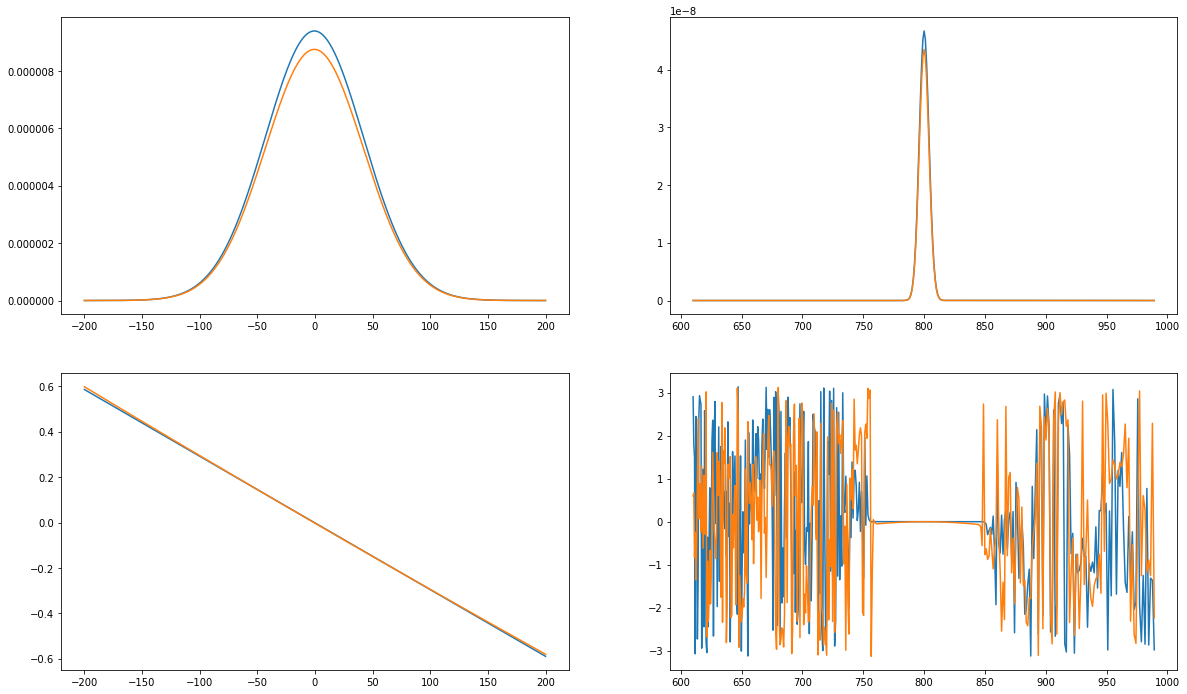

In [26]:

plt.clf()
fig = plt.figure(1, figsize=(100,50), dpi=80, facecolor='w', edgecolor='k', frameon=True)  
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(tROI, np.square(np.absolute(At0)))
ax1.plot(tROI,np.square(np.absolute(AtF)))

ax2.plot(lROI*1e9, np.square(np.absolute(Aw0)))
ax2.plot(lROI*1e9, np.square(np.absolute(AwF)))

ax3.plot(tROI,np.angle(At0))
ax3.plot(tROI,np.angle(AtF))

ax4.plot(lROI*1e9, np.angle(Aw0))
ax4.plot(lROI*1e9, np.angle(AwF))

fig.set_figheight(12)
fig.set_figwidth(20)
plt.show()